In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import os
from buffer import Buffer
import math

In [2]:
%matplotlib notebook

In [3]:
def read_vid_frame(fpath, nframe=1):
    VID_PATH = fpath
    IMG_WIDTH = 480
    IMG_HEIGHT = 270
    IMG_DEPTH = 3
    IMG_AREA = IMG_WIDTH * IMG_HEIGHT
    
    vid_f = open(VID_PATH, 'rb')
    vid_f_size = IMG_WIDTH * IMG_HEIGHT * IMG_DEPTH
    
    # skip over undesired frames without processing
    for i in range(nframe):
        vid_f.read(vid_f_size)
    
    bit_str = vid_f.read(vid_f_size)
    bit_arr = np.frombuffer(bit_str, np.uint8)
    img = np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH), dtype=np.uint8)
    
    for d in range(IMG_DEPTH):
        channel = np.reshape(bit_arr[d * IMG_AREA:(d+1) * IMG_AREA], 
                             (IMG_HEIGHT, IMG_WIDTH))
        img[:,:,d] = channel
    
    vid_f.close()
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    return img

def read_img(fpath):
    VID_PATH = fpath
    IMG_WIDTH = 480
    IMG_HEIGHT = 270
    IMG_DEPTH = 3
    IMG_AREA = IMG_WIDTH * IMG_HEIGHT
    
    vid_f = open(VID_PATH, 'rb')
    vid_f_size = IMG_WIDTH * IMG_HEIGHT * IMG_DEPTH
    
    bit_str = vid_f.read(vid_f_size)
    bit_arr = np.frombuffer(bit_str, np.uint8)
    img = np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH), dtype=np.uint8)
    
    for d in range(IMG_DEPTH):
        channel = np.reshape(bit_arr[d * IMG_AREA:(d+1) * IMG_AREA], 
                             (IMG_HEIGHT, IMG_WIDTH))
        img[:,:,d] = channel
    
    vid_f.close()
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    return img

In [4]:
# Load Ads
data_dir = '../data/dataset1/Brand Images/'
brand_img_paths = []
for f in os.listdir(data_dir):
    if f.split('.')[-1] == 'rgb':
        brand_img_paths.append(data_dir + f)

print("Ad files found:")
print([f for f in brand_img_paths])

brand_imgs = {}
for f in brand_img_paths:
    brand_name = f.split('/')[-1].split('_')[0]
    img = read_img(f)
    if brand_name not in brand_imgs:
        brand_imgs[brand_name] = img
    #brand_imgs.append(img)

print("Read {} brand images".format(len(brand_imgs)))

FileNotFoundError: [Errno 2] No such file or directory: '../data/dataset1/Brand Images/'

In [4]:
# Load selected Video frames
# Starbucks selected frames:
# 4485
# 4717
# 5064
# 5288

vid_data_f = '../data/dataset1/Videos/data_test1.rgb'

# Starbucks frames:
#frame_indices = [4485, 4717, 5064, 5288]

# Subway frames:
frame_indices = [1502, 1665, 1801, 2057, 2202]

video_imgs = []

for i in frame_indices:
    img = read_vid_frame(vid_data_f, i)
    video_imgs.append(img)
    


In [13]:
# Print selected ad image
cv2.imshow("", brand_imgs['starbucks'])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
# Print selected video frame
cv2.imshow("", video_frames[3])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [50]:
# Do some object detection test
video_img = video_imgs[0]
brand_img = brand_imgs['starbucks']

# initialize detector
feature_detector = cv2.ORB_create()

# detect keypoints
video_img_kps = feature_detector.detect(video_img, None)
brand_img_kps = feature_detector.detect(brand_img, None)

# get descriptors
video_kps, video_des = feature_detector.compute(video_img, video_img_kps)
brand_kps, brand_des = feature_detector.compute(brand_img, brand_img_kps)

# Draw descriptors
video_img_orb = cv2.drawKeypoints(video_img, video_kps, None, color=(0,255,0), flags=0)
brand_img_orb = cv2.drawKeypoints(brand_img, brand_kps, None, color=(0,255,0), flags=0)

<IPython.core.display.Javascript object>


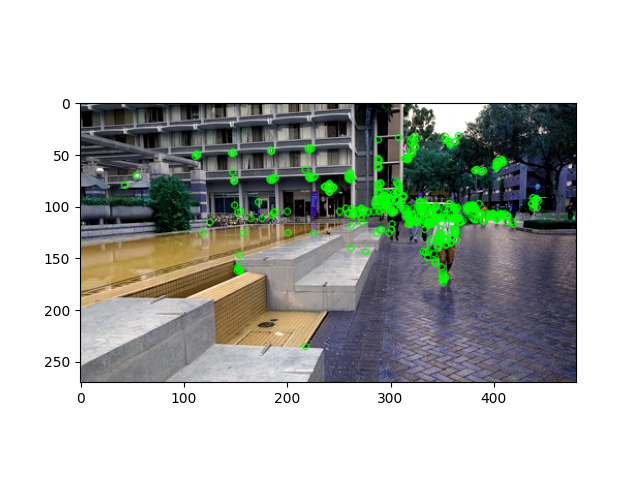

<IPython.core.display.Javascript object>


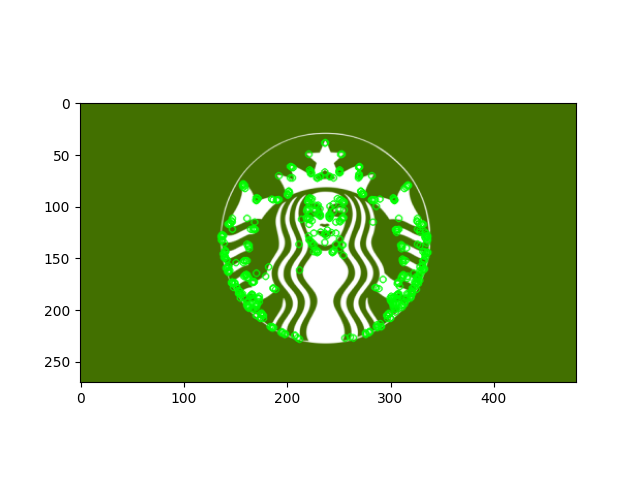

In [51]:
# Display keypoints
plt.figure()
plt.imshow(video_img_orb)
plt.figure()
plt.imshow(brand_img_orb)

In [54]:
# Do feature matching test (uses data from object detection cell so run that first)
# Brute force matcher
bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf_matcher.match(video_des, brand_des)

# sort in order of hamming distance (low distance => better match)
matches = sorted(matches, key = lambda x:x.distance)

# draw first N matches
N = -1
bf_matcher_img = cv2.drawMatches(video_img, video_img_kps, brand_img, brand_img_kps, 
                                 matches[:N], None, 
                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

<IPython.core.display.Javascript object>


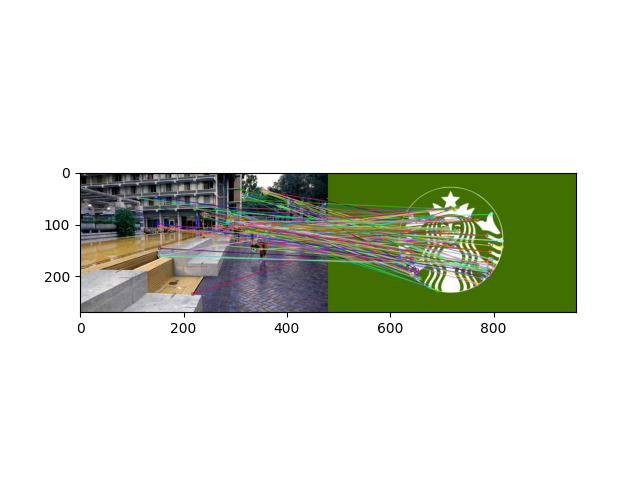

In [55]:
plt.figure()
plt.imshow(bf_matcher_img)

In [57]:
# Do feature matching test (uses data from object detection cell so run that first)
# FLANN-based matcher

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann_matcher = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann_matcher.knnMatch(video_des.astype(np.float32),
                                 brand_des.astype(np.float32),
                                 k=2)

ratio_test_matches = []
for m,n in matches:
    if m.distance < 0.8 * n.distance:
        ratio_test_matches.append(m)
        

flann_matcher_img = cv2.drawMatches(video_img, video_img_kps, brand_img, brand_img_kps,
                                    ratio_test_matches, None,
                                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

<IPython.core.display.Javascript object>


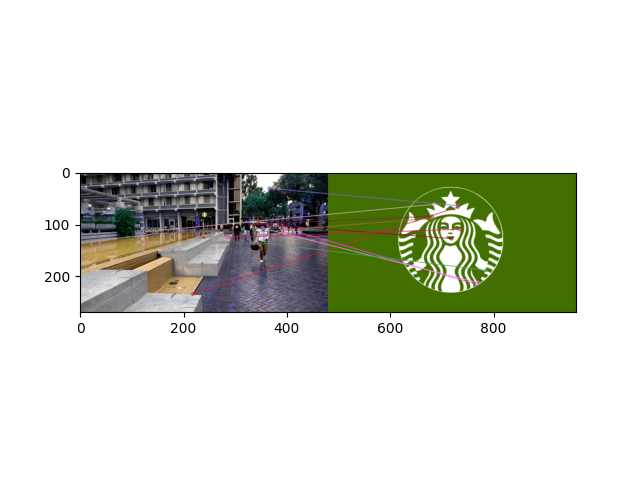

In [58]:
plt.figure()
plt.imshow(flann_matcher_img)

### Try object detection again with rescaled brand images

In [11]:
?? cv2.resize

In [7]:
sb_brand_imgs_rescale = [cv2.resize(brand_imgs['starbucks'], None, fx=scale, fy=scale) for scale in np.arange(0.1, 1.1, 0.1)]

<IPython.core.display.Javascript object>


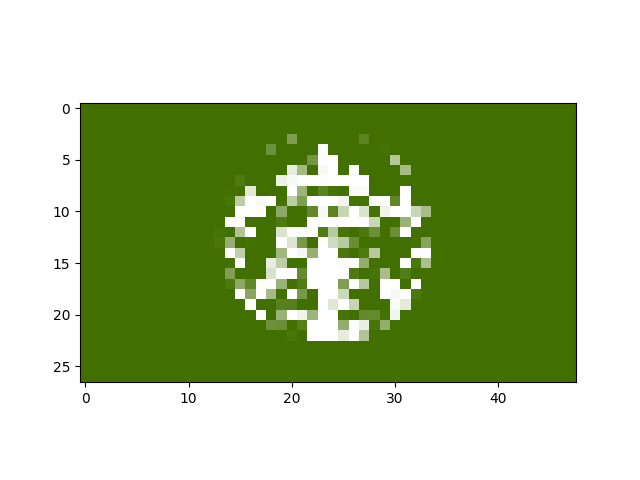

In [8]:
plt.figure()
plt.imshow(sb_brand_imgs_rescale[0])

In [9]:
# Do feature extraction 
video_img = video_imgs[0].astype(np.uint8)
brand_img = sb_brand_imgs_rescale[0].astype(np.uint8)

# initialize detector
#feature_detector = cv2.ORB_create()
feature_detector = cv2.ORB_create(edgeThreshold=3, patchSize=5)

# detect keypoints
video_img_kps = feature_detector.detect(video_img, None)
brand_img_kps = feature_detector.detect(brand_img, None)

# get descriptors
video_kps, video_des = feature_detector.compute(video_img, video_img_kps)
brand_kps, brand_des = feature_detector.compute(brand_img, brand_img_kps)

# Draw descriptors
video_img_orb = cv2.drawKeypoints(video_img.astype(np.uint8), video_kps, None, color=(0,255,0), flags=0)
brand_img_orb = cv2.drawKeypoints(brand_img.astype(np.uint8), brand_kps, None, color=(0,255,0), flags=0)

In [15]:
print(feature_detector.getPatchSize())
print(feature_detector.getEdgeThreshold())
print(feature_detector.getScaleFactor())
print(feature_detector.getNLevels())
print(feature_detector.getFirstLevel())
print(feature_detector.getWTA_K())

5
3
1.2000000476837158
8
0
2


<IPython.core.display.Javascript object>


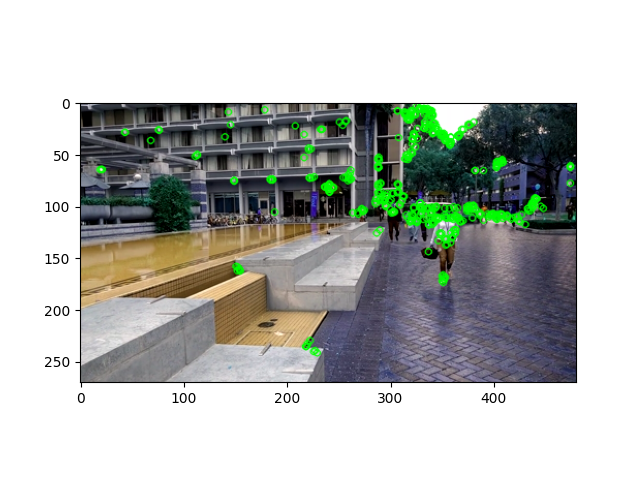

<IPython.core.display.Javascript object>


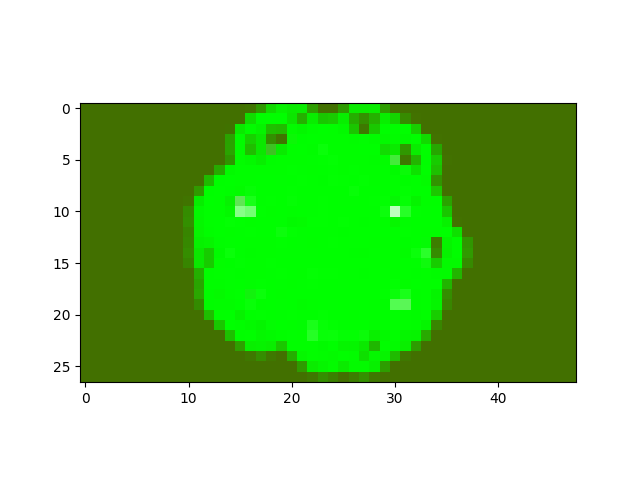

In [11]:
# Display keypoints
plt.figure()
plt.imshow(video_img_orb)
plt.figure()
plt.imshow(brand_img_orb)

In [29]:
# Do feature matching test (uses data from object detection cell so run that first)
# Brute force matcher
bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf_matcher.match(video_des, brand_des)
#matches = bf_matcher.knnMatch(video_des, brand_des, k=1)

# sort in order of hamming distance (low distance => better match)
matches = sorted(matches, key = lambda x:x.distance)

#matches = [m[0] for m in matches if m]

#ratio_test_matches = []
#for m, n in matches:
#    if m.distance < 0.5*n.distance:
#        ratio_test_matches.append(m)

# draw first N matches
N = 20
bf_matcher_img = cv2.drawMatches(video_img, video_img_kps, brand_img, brand_img_kps, 
                                 matches[:N], None, 
                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

#bf_matcher_img = cv2.drawMatches(video_img, video_img_kps, brand_img, brand_img_kps, 
#                                 ratio_test_matches, None, 
#                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

#bf_matcher_img = cv2.drawMatches(video_img, video_img_kps, brand_img, brand_img_kps, 
#                                 matches, None, 
#                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

<IPython.core.display.Javascript object>


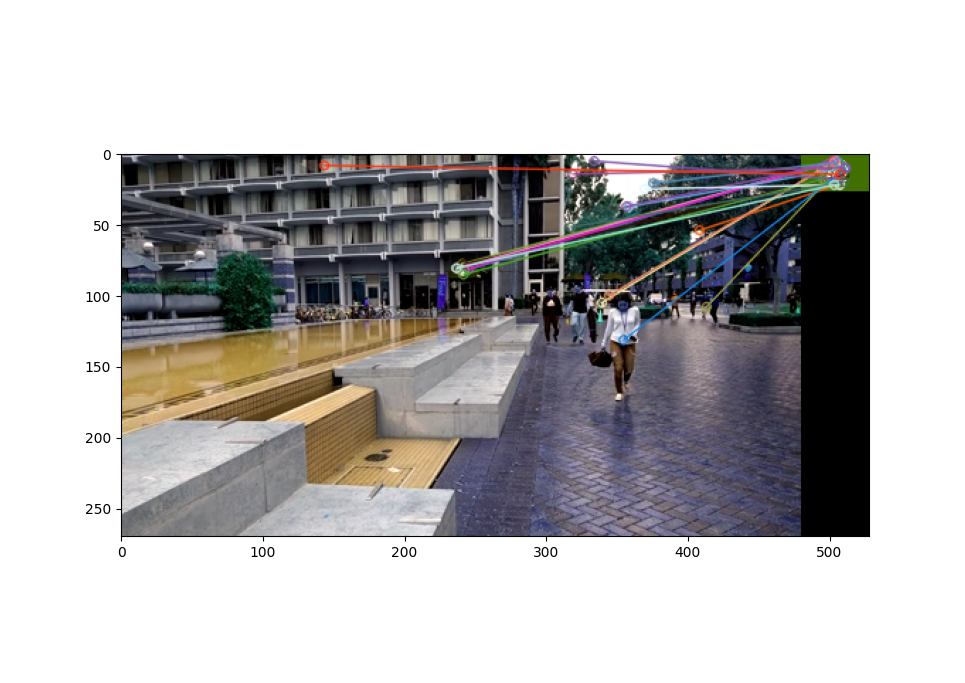

In [30]:
plt.figure()
plt.imshow(bf_matcher_img)

In [17]:
??cv2.resize

In [15]:
?? np.arange

In [16]:
np.arange(0.2, 1.1, 0.2)

array([0.2, 0.4, 0.6, 0.8, 1. ])

### Auto-rescale brand image 

In [96]:
#sb_brand_imgs_rescale = [cv2.resize(brand_imgs['starbucks'], None, fx=scale, fy=scale) for scale in np.arange(0.1, 1.1, 0.1)]
su_brand_imgs_rescale = [cv2.resize(brand_imgs['subway'], None, fx=scale, fy=scale) for scale in np.arange(0.1, 1.1, 0.1)]

In [183]:
# Do feature extraction 
video_img = video_imgs[4]
brand_img = su_brand_imgs_rescale[0]

# initialize detector
#feature_detector = cv2.ORB_create()
feature_detector = cv2.ORB_create(edgeThreshold=math.ceil(brand_img.shape[0]/10),
                                  patchSize=brand_img.shape[0]//5)

# detect keypoints
video_img_kps = feature_detector.detect(video_img, None)
brand_img_kps = feature_detector.detect(brand_img, None)

# get descriptors
video_kps, video_des = feature_detector.compute(video_img, video_img_kps)
brand_kps, brand_des = feature_detector.compute(brand_img, brand_img_kps)

# Draw descriptors
video_img_orb = cv2.drawKeypoints(video_img.astype(np.uint8), video_kps, None, color=(0,255,0), flags=0)
brand_img_orb = cv2.drawKeypoints(brand_img.astype(np.uint8), brand_kps, None, color=(0,255,0), flags=0)

In [184]:
print(feature_detector.getPatchSize())
print(feature_detector.getEdgeThreshold())
print(feature_detector.getScaleFactor())
print(feature_detector.getNLevels())
print(feature_detector.getFirstLevel())
print(feature_detector.getWTA_K())

5
3
1.2000000476837158
8
0
2


<IPython.core.display.Javascript object>


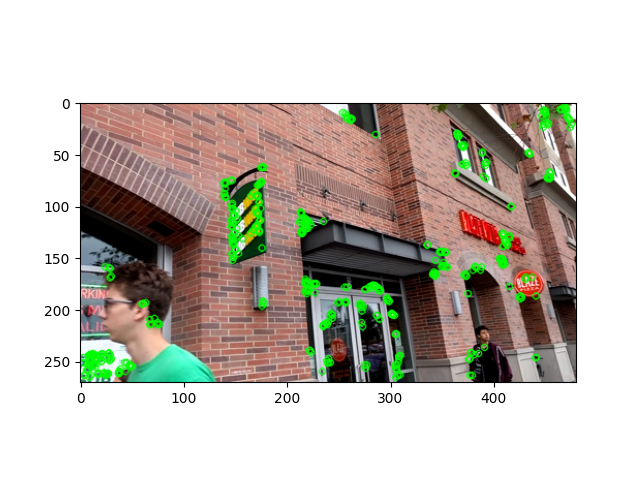

<IPython.core.display.Javascript object>


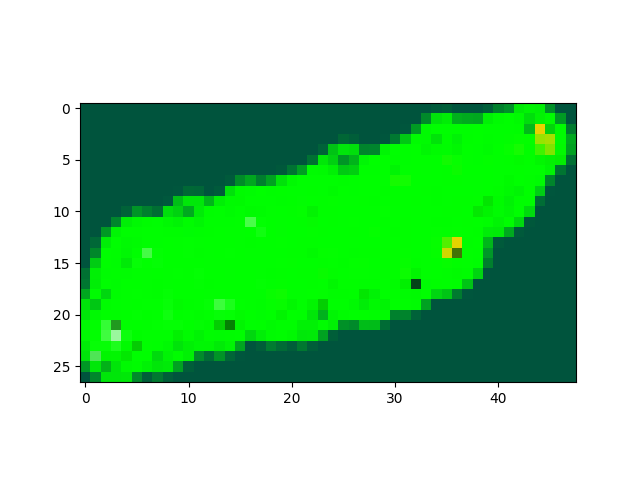

In [185]:
# Display keypoints
plt.figure()
plt.imshow(cv2.cvtColor(video_img_orb, cv2.COLOR_BGR2RGB))
plt.figure()
plt.imshow(cv2.cvtColor(brand_img_orb, cv2.COLOR_BGR2RGB))

In [188]:
# Do feature matching test (uses data from object detection cell so run that first)
# Brute force matcher
bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf_matcher.match(video_des, brand_des)
#matches = bf_matcher.knnMatch(video_des, brand_des, k=1)

# sort in order of hamming distance (low distance => better match)
matches = sorted(matches, key = lambda x:x.distance)

#matches = [m[0] for m in matches if m]

#ratio_test_matches = []
#for m, n in matches:
#    if m.distance < 0.5*n.distance:
#        ratio_test_matches.append(m)

# draw first N matches
N = -1
bf_matcher_img = cv2.drawMatches(video_img, video_img_kps, brand_img, brand_img_kps, 
                                 matches[:N], None, 
                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

#bf_matcher_img = cv2.drawMatches(video_img, video_img_kps, brand_img, brand_img_kps, 
#                                 ratio_test_matches, None, 
#                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

#bf_matcher_img = cv2.drawMatches(video_img, video_img_kps, brand_img, brand_img_kps, 
#                                 matches, None, 
#                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

<IPython.core.display.Javascript object>


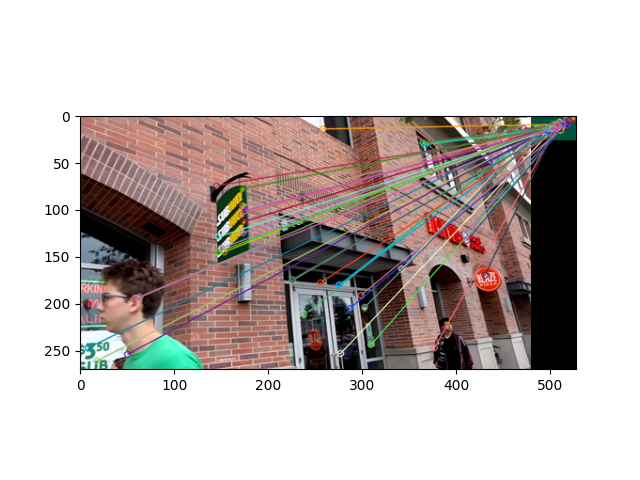

In [187]:
plt.figure()
plt.imshow(cv2.cvtColor(bf_matcher_img, cv2.COLOR_BGR2RGB))